# CS F415 Data Mining - Home Loan Approval

### Problem Statement & Data Set
Suppose a Finance Company offers home loans across urban, semi-urban,
and rural areas. The loan approval process typically spans 1 week to 1 month
due to extensive customer research.To streamline this, we'll employ Data
Mining techniques to automate and expedite loan approvals.

### About the dataset
The loan application data set includes various columns that provide
information on the applicant and the loan, such as Loan ID, Gender, Marital
Status,Dependents, Education, Self-Employment status, Applicant Income,
Co-Applicant Income, Loan Amount, Loan Amount Term, Credit History, and
Property Area.

### 1. Importing Dependencies and Datasets

In [6]:
!poetry add pandas numpy matplotlib seaborn scikit-learn

The following packages are already present in the pyproject.toml and will be skipped:

  - pandas
  - numpy
  - matplotlib
  - seaborn
  - scikit-learn

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data Analysis & Visualization
We have two csv files: train & test.

Train file contains all independent variables and target variables which'll be used to train the model. (i.e. train csv has loan_status column, but test csv doesn't)

Test file has independent variables, but not the target variables. This model will predict test variables for the test data.

In [8]:
train=pd.read_csv(r"./datasets/loan_sanction_train.csv")
test=pd.read_csv(r"./datasets/loan_sanction_test.csv")

In [9]:
print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### Checking for duplicates and missing values

In [10]:
print(f"No. of duplicates: {train.duplicated().sum()}")
train.isnull().sum()

No. of duplicates: 0


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

* We have no duplicates, but have several missing values

In [11]:
train.select_dtypes('object').nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64


* Since the value of Loan_Id is unique for each row, we can remove Loan_ID as it won't be useful in model training.

In [12]:
train.drop(columns=['Loan_ID'],inplace=True)

In [13]:
train.describe(include="number") # describing numerical data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [14]:
desc = train.describe(exclude="number") # describing categorical data

for col in desc.columns:
    top_category = desc.loc['top', col]
    percentage = ((train[col] == top_category).mean()*100).round(2)
    desc.loc['top_percentage', col] = percentage

desc

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,489,398,345,480,500,233,422
top_percentage,79.64,64.82,56.19,78.18,81.43,37.95,68.73


* There are more Male(79.64%) applicants than Female.
* Frequency of Married(64.82%) applicants is more.
* There are more Graduate(78.18%) applicants.

### Data Visualization

In [15]:
train['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [16]:
train['Loan_Status'].value_counts(normalize=True)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

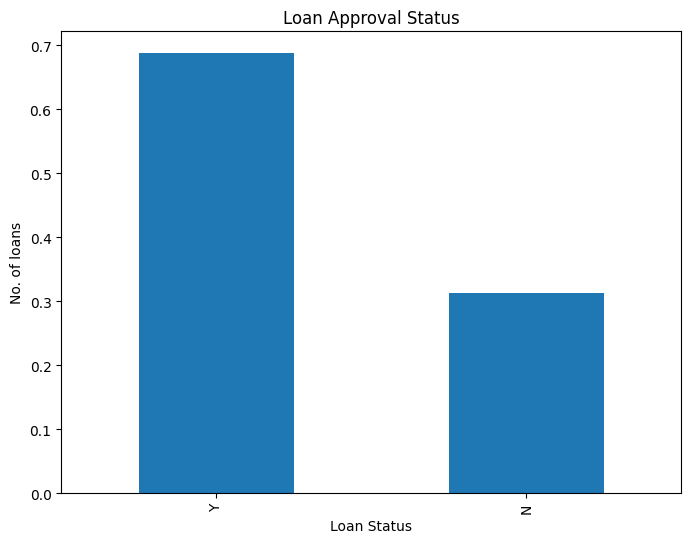

In [17]:
plt.figure(figsize=(8, 6))
train['Loan_Status'].value_counts(normalize=True).plot.bar()
plt.title('Loan Approval Status')
plt.xlabel('Loan Status')
plt.ylabel('No. of loans')
plt.show()

* Around 68.72% of people got their loans approved.

#### Gender Distribution

In [18]:
train['Gender'].value_counts()

Gender
Male      489
Female    112
Name: count, dtype: int64

In [19]:
train['Gender'].value_counts(normalize=True)

Gender
Male      0.813644
Female    0.186356
Name: proportion, dtype: float64

In [20]:
gender_counts = train['Gender'].value_counts(normalize=True).reset_index()
gender_counts.columns = ['Gender', 'Percentage']

fig = px.bar(gender_counts,
             x='Gender',
             y='Percentage',
             text='Percentage',
             labels={'Percentage': 'Ratio'},
             color='Gender',
             color_discrete_sequence=['blue', 'orange'],
             title='Gender Distribution',
             hover_data={'Gender': False, 'Percentage': ':.2%'},
             width=800, height=500)
fig.show()

* Around 81.36% of loan applicants are male.

#### Martial Status Distribution

In [21]:
#Here we create a dataframe which contains counts and ratios
married_counts = train['Married'].value_counts(normalize=True).reset_index()
married_counts.columns = ['Married', 'Percentage']

fig = px.bar(married_counts,
             x='Married',
             y='Percentage',
             text='Percentage',                           #Percentage on bar graphs
             labels={'Percentage': 'Ratio'},              #Setting the y-axis name
             color='Married',
             color_discrete_sequence=['blue', 'orange'], 
             title='Marital Status Distribution',
             hover_data={'Married': False, 'Percentage': ':.2%'},
             width=800, height=500)

fig.show()

* 65.13% of people who applied for a loan are married

#### Self Employment Status Distribution

In [22]:
self_employed_counts = train['Self_Employed'].value_counts(normalize=True).reset_index()
self_employed_counts.columns = ['Self_Employed', 'Percentage']

fig = px.bar(self_employed_counts,
             x='Self_Employed',
             y='Percentage',
             text='Percentage',
             labels={'Percentage': 'Ratio'},
             color='Self_Employed',
             color_discrete_sequence=['#1f77b4', '#ff7f0e'],  
             title='Self Employment Status Distribution',
             hover_data={'Percentage': ':.2%'},
             width=800, height=500)
fig.show()

85.91% of people who applied for a loan are self employed

#### Credit History Distribution

In [23]:
credit_history_counts = train['Credit_History'].value_counts(normalize=True).reset_index()
credit_history_counts.columns = ['Credit_History', 'Percentage']

fig = px.bar(credit_history_counts,
             x='Credit_History',
             y='Percentage',
             text='Percentage',
             labels={'Percentage': 'Ratio'},
             color='Credit_History',
             color_discrete_sequence=['blue', 'purple'],
             title='Credit History Distribution',
             hover_data={'Credit_History': False, 'Percentage': ':.2%'},
             width=800, height=500)
fig.show()

around 84.21% of applicants have repayed their depts

### Categorical Distributions

In [24]:
import plotly.subplots as sp
import plotly.graph_objects as go

fig = sp.make_subplots(rows=1, cols=3, subplot_titles=['Dependents', 'Education', 'Property Area'])

# Dependents
fig.add_trace(go.Bar(x=train['Dependents'].value_counts(normalize=True).index,   #takes unique index values of normalized counts
                     y=train['Dependents'].value_counts(normalize=True),
                     name='Dependents'),
                     row=1, col=1)

# Education
fig.add_trace(go.Bar(x=train['Education'].value_counts(normalize=True).index,
                     y=train['Education'].value_counts(normalize=True),
                     name='Education'),
              row=1, col=2)

# Property Area
fig.add_trace(go.Bar(x=train['Property_Area'].value_counts(normalize=True).index,
                     y=train['Property_Area'].value_counts(normalize=True),
                     name='Property Area'),
              row=1, col=3)

fig.show()

- Lesser part of the applicants have dependents
- 78% of applicants are graduates
- There is no big difference in number of people from semiurban, urban, rural however among them most of the applicants are from semiurban

#### Loan Status by Gender

In [25]:
gender_loan_crosstab = pd.crosstab(train['Gender'], train['Loan_Status'])  #counts the occurences of each combination of genders and loan statuses

# Calculate the percentage distribution
gender_loan_percentage = gender_loan_crosstab.div(gender_loan_crosstab.sum(1).astype(float), axis=0)

#Now we reset the dataframe indices to make it suitable for further processing
gender_loan_percentage.reset_index(inplace=True)

# Create traces for each loan status
trace_not_approved = go.Bar(
    x=gender_loan_percentage['Gender'],
    y=gender_loan_percentage['N'],
    name='Not Approved',
    marker=dict(color='red')
)

trace_approved = go.Bar(
    x=gender_loan_percentage['Gender'],
    y=gender_loan_percentage['Y'],
    name='Approved',
    marker=dict(color='green')
)

layout = go.Layout(
    title='Loan Status by Gender',
    xaxis=dict(title='Gender'),
    yaxis=dict(title='Percentage'),
    barmode='stack',
)

fig = go.Figure(data=[trace_not_approved, trace_approved],layout=layout)
fig.show()

* Proportion of male and female applicants is nearly same for both approved and unapproved loans. Since it's also unethical to deny loan based on gender, we will drop the Gender attribute.

In [26]:
# drop gender column
train.drop(columns=['Gender'], inplace=True)

#### Loan Approval Status by Categorical Variables

In [27]:
# Crosstabs
married_crosstab = pd.crosstab(train['Married'], train['Loan_Status'])
dependents_crosstab = pd.crosstab(train['Dependents'], train['Loan_Status'])
education_crosstab = pd.crosstab(train['Education'], train['Loan_Status'])
self_employed_crosstab = pd.crosstab(train['Self_Employed'], train['Loan_Status'])

# Normalize Crosstabs
married_normalized = married_crosstab.div(married_crosstab.sum(1).astype(float), axis=0)
dependents_normalized = dependents_crosstab.div(dependents_crosstab.sum(1).astype(float), axis=0)
education_normalized = education_crosstab.div(education_crosstab.sum(1).astype(float), axis=0)
self_employed_normalized = self_employed_crosstab.div(self_employed_crosstab.sum(1).astype(float), axis=0)

# Create subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=['Married', 'Dependents', 'Education', 'Self Employed'],
                       specs=[[{'type': 'bar'}, {'type': 'bar'}],
                              [{'type': 'bar'}, {'type': 'bar'}]])

# Married subplot
fig.add_trace(go.Bar(x=married_normalized.index, y=married_normalized['Y'], name='Approved'),
              row=1, col=1)
fig.add_trace(go.Bar(x=married_normalized.index, y=married_normalized['N'], name='Not Approved'),
              row=1, col=1)
# Dependents subplot
fig.add_trace(go.Bar(x=dependents_normalized.index, y=dependents_normalized['Y'], name='Approved'),
              row=1, col=2)
fig.add_trace(go.Bar(x=dependents_normalized.index, y=dependents_normalized['N'], name='Not Approved'),
              row=1, col=2)

# Education subplot
fig.add_trace(go.Bar(x=education_normalized.index, y=education_normalized['Y'], name='Approved'),
              row=2, col=1)
fig.add_trace(go.Bar(x=education_normalized.index, y=education_normalized['N'], name='Not Approved'),
              row=2, col=1)
# Self Employed subplot
fig.add_trace(go.Bar(x=self_employed_normalized.index, y=self_employed_normalized['Y'], name='Approved'),
              row=2, col=2)
fig.add_trace(go.Bar(x=self_employed_normalized.index, y=self_employed_normalized['N'], name='Not Approved'),
              row=2, col=2)

# Update layout
fig.update_layout(title_text='Loan Approval Status by Categorical Variables',barmode='stack',showlegend=False)

fig.show()

- 71.6% of the married applicants have approved loans where as only 62.9% of loans are approved for unmarried applicants
- Applicants having 2 dependents have higher proportions of loan approval than others
- Graduates have higher proportions of approved loan
- Nothing can be inferred from Self Employed graph, thus we can also drop this

In [28]:
train.drop(columns=['Self_Employed'], inplace=True)

#### Loan Approval Status by Credit History and Property Area

In [29]:
df=train[['Credit_History','Property_Area']]
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Credit History', 'Property Area'],
                       specs=[[{'type': 'bar'}, {'type': 'bar'}]])

credit_crosstab=pd.crosstab(train['Credit_History'],train['Loan_Status'])
property_crosstab=pd.crosstab(train['Property_Area'],train['Loan_Status'])

credit_normalized=credit_crosstab.div(credit_crosstab.sum(1).astype(float), axis=0)
property_normalized=property_crosstab.div(property_crosstab.sum(1).astype(float), axis=0)

fig.add_trace(go.Bar(x=credit_normalized.index, y=credit_normalized['Y'], name='Approved'), row=1, col=1)
fig.add_trace(go.Bar(x=credit_normalized.index, y=credit_normalized['N'], name='Not Approved'), row=1, col=1)

fig.add_trace(go.Bar(x=property_normalized.index, y=property_normalized['Y'], name='Approved'), row=1, col=2)
fig.add_trace(go.Bar(x=property_normalized.index, y=property_normalized['N'], name='Not Approved'), row=1, col=2)

fig.update_layout(title_text='Loan Approval Status by Credit History and Property Area',barmode='stack',showlegend=False)

fig.show()

- Applicants having Credit History of 1 have far more higher approval percentage than applicants having Credit History 0.
- The proportion of loans getting approved in semi-urban areas is higher as compared to that in rural or urban areas.

#### Visualizing Numerical Data

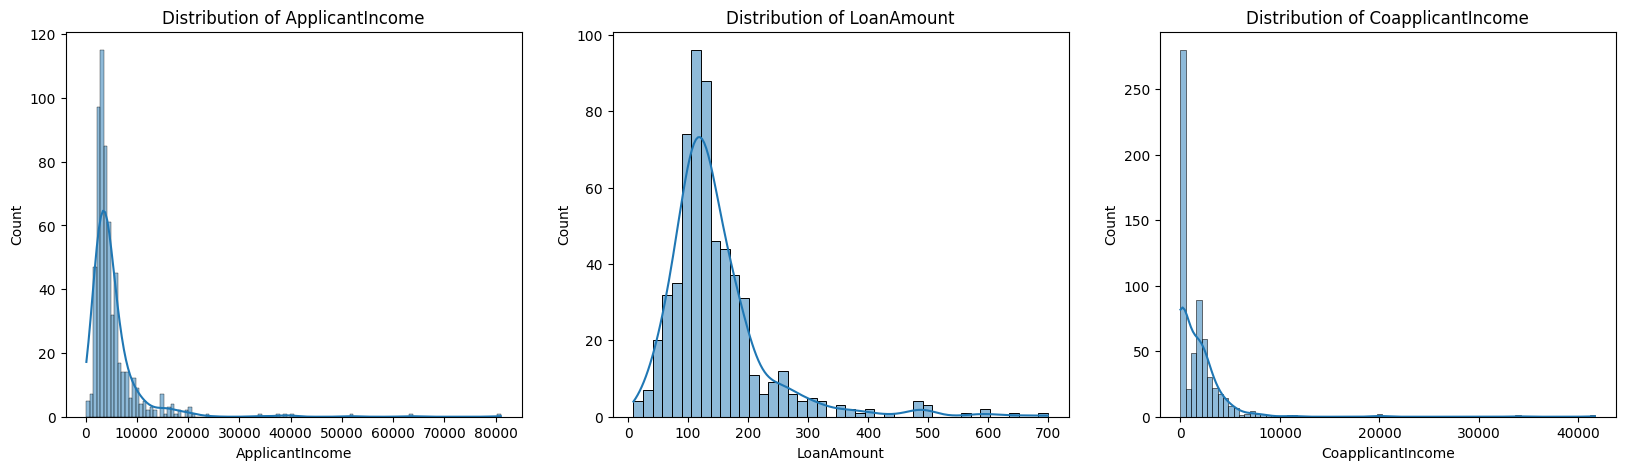

In [30]:
df = train[['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome']]

fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,features in enumerate(df):
    sns.histplot(data=train,x=features,ax=ax[i],kde=True)
    ax[i].set_title(f'Distribution of {features}')

* Applicant Income,LoanAmount & Coapplicant Income have outliers.

##### Applicant Income v/s Loan Status

* Since ApplicantIncome,CoapplicantIncome and LoanAmount have outliers, we'll divide them into equi-freq bins 

In [31]:
qbins = pd.qcut(train['ApplicantIncome'], q=4)  # q is the number of bins

print(qbins.value_counts())

bins = [0, 2877.5, 3812.5, 5795.0, 81000.0]

labels = ['Low', 'Average', 'High', 'Very high']

train['Income_bin'] = pd.cut(train['ApplicantIncome'], bins, labels=labels) #Here we added Income bin to our datadrame using pd.cut, which helps in binning

income_bin_crosstab = pd.crosstab(train['Income_bin'], train['Loan_Status'])

income_bin_normalized = income_bin_crosstab.div(income_bin_crosstab.sum(1).astype(float), axis=0)

fig = px.bar(income_bin_normalized,
             x=income_bin_normalized.index,
             y=['Y', 'N'],
             title='Loan Approval Status by Applicant Income',
             labels={'value': 'Percentage', 'variable': 'Loan Status'},
             category_orders={'Income_bin': labels},
             color_discrete_sequence=['green', 'red'],
             width=800, height=500)
fig.show()

train = train.drop(columns=['Income_bin'])


ApplicantIncome
(149.999, 2877.5]    154
(5795.0, 81000.0]    154
(2877.5, 3812.5]     153
(3812.5, 5795.0]     153
Name: count, dtype: int64


It can be inferred that Applicant’s income does not affect the chances of loan approval much which is not so trivial as we assumed that if the applicant’s income is high the chances of loan approval will also be high.

In [32]:
count = (train['CoapplicantIncome'] == 0).sum()
print(f'No of Zeroes in CoapplicantIncome: {count}')

No of Zeroes in CoapplicantIncome: 273


We can see that 273 out of 614 rows do not have a coapplicant income. Hence, there may be cases in which applicant income is low but he also has a coapplicant, so he was granted a loan. Hence, a better parameter would be to create a new feature, total income.

In [33]:
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']

qbins = pd.qcut(train['TotalIncome'], q=4)  # q is the number of bins

print(qbins.value_counts())

bins = [0, 4166.0, 5416.5, 7521.75, 81000.0]
labels = ['Low', 'Average', 'High','Very High']

train['TotalIncome_bin'] = pd.cut(train['TotalIncome'], bins, labels=labels) #Here we added Total Income bin to our dataframe using pd.cut, which helps in binning

income_bin_crosstab = pd.crosstab(train['TotalIncome_bin'], train['Loan_Status'])

income_bin_normalized = income_bin_crosstab.div(income_bin_crosstab.sum(1).astype(float), axis=0)

fig = px.bar(income_bin_normalized,
             x=income_bin_normalized.index,
             y=['Y', 'N'],
             title='Loan Approval Status by Total Income',
             labels={'value': 'Percentage', 'variable': 'Loan Status'},
             category_orders={'TotalIncome_bin': labels},
             color_discrete_sequence=['green', 'red'],
             width=800, height=500)
fig.show()

train.drop(columns=['TotalIncome_bin'],inplace=True)
train.drop(columns=['ApplicantIncome','CoapplicantIncome'],inplace=True)


TotalIncome
(1441.999, 4166.0]    155
(7521.75, 81000.0]    154
(5416.5, 7521.75]     153
(4166.0, 5416.5]      152
Name: count, dtype: int64


* Loan Status is not significantly impacted by Total Income.

##### Loan Amount v/s Loan Status

In [34]:
qbins = pd.qcut(train['LoanAmount'], q=4)  # q is the number of bins

print(qbins.value_counts())

bins = [0, 100, 128, 168, 700]

labels = ['Low', 'Average', 'High', 'Very high']

train['LoanBin'] = pd.cut(train['LoanAmount'], bins, labels=labels) 

LoanBin_crosstab = pd.crosstab(train['LoanBin'], train['Loan_Status'])

LoanBin_normalized = LoanBin_crosstab.div(LoanBin_crosstab.sum(1).astype(float), axis=0)

fig = px.bar(LoanBin_normalized,
             x=LoanBin_normalized.index,
             y=['Y', 'N'],
             title='Loan Approval Status by Loan Amount',
             labels={'value': 'Percentage', 'variable': 'Loan Status'},
             category_orders={'LoanBin': labels},
             color_discrete_sequence=['green', 'red'],
             width=800, height=500)
fig.show()

train = train.drop(columns=['LoanBin'])


LoanAmount
(8.999, 100.0]    154
(100.0, 128.0]    152
(168.0, 700.0]    146
(128.0, 168.0]    140
Name: count, dtype: int64


#### Loan Amount v/s Total Income

<Axes: xlabel='TotalIncome', ylabel='LoanAmount'>

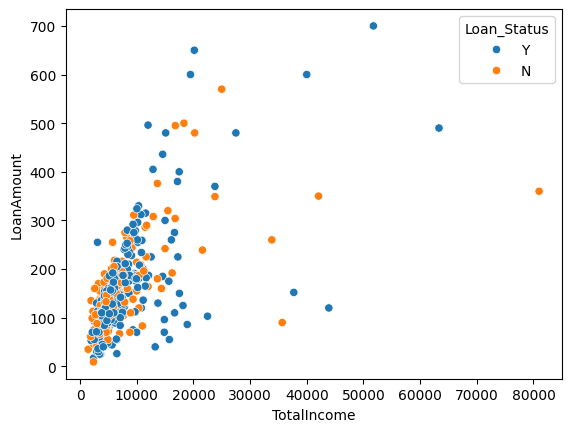

In [35]:
import seaborn as sns

sns.scatterplot(x='TotalIncome', y='LoanAmount', hue='Loan_Status', data=train)


##### Correlation Matrix

In [36]:
train.replace({'Loan_Status':{'N': 0}}, inplace=True)
train.replace({'Loan_Status':{'Y': 1}}, inplace=True)

/var/folders/2s/v783hrsx7ld3cdp_cm9ghqd80000gn/T/ipykernel_69965/2360083338.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



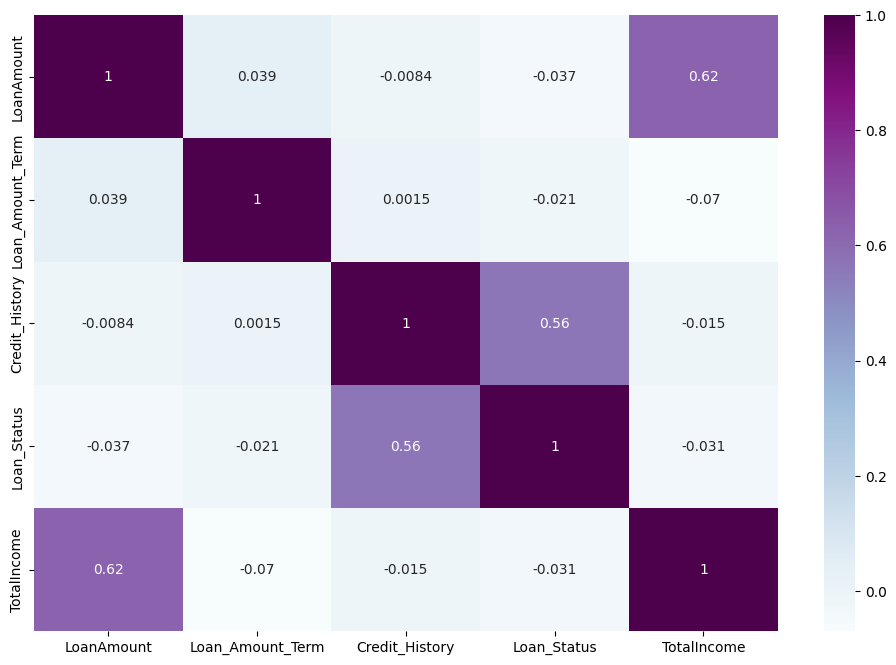

In [37]:
fig_dims=(12,8)
fig,ax=plt.subplots(figsize=fig_dims)

num_features=train.select_dtypes(include='number')
sns.heatmap(num_features.corr(),annot=True,ax=ax, cmap='BuPu')
plt.show()

* Loan_Status has good correlation with only Credit_History, and has weak correaltion with other numerical attributes.

### Missing Value Treatment

In [38]:
train.isnull().sum()

Married              3
Dependents          15
Education            0
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
Property_Area        0
Loan_Status          0
TotalIncome          0
dtype: int64

* Now we replace the categorical attributes with their mode.

In [39]:
train.fillna({
              'Married':train['Married'].mode()[0],
              'Dependents':train['Dependents'].mode()[0],
              'Credit_History':train['Credit_History'].mode()[0]
              },
            inplace=True)


In [40]:
train.isnull().sum()

Married              0
Dependents           0
Education            0
LoanAmount          22
Loan_Amount_Term    14
Credit_History       0
Property_Area        0
Loan_Status          0
TotalIncome          0
dtype: int64

In [41]:
train['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

We can see that the value 360 is being repeated very frequently for Loan_Amount_Term. Hence it would be a good idea to replace the missing values with the mode.

In [42]:
train.fillna({'Loan_Amount_Term':train['Loan_Amount_Term'].mode()[0]}, inplace=True)

Since loan amount is a numerical attribute and it had some outliers value(as we can see in our previously plotted graph), we can consider median to be an appropriate value for missing values.

In [43]:
train.fillna({'LoanAmount':train['LoanAmount'].median()}, inplace=True)

In [44]:
train.isnull().sum()

Married             0
Dependents          0
Education           0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Loan_Status         0
TotalIncome         0
dtype: int64

* No Missing values exist

### Handling Outliers

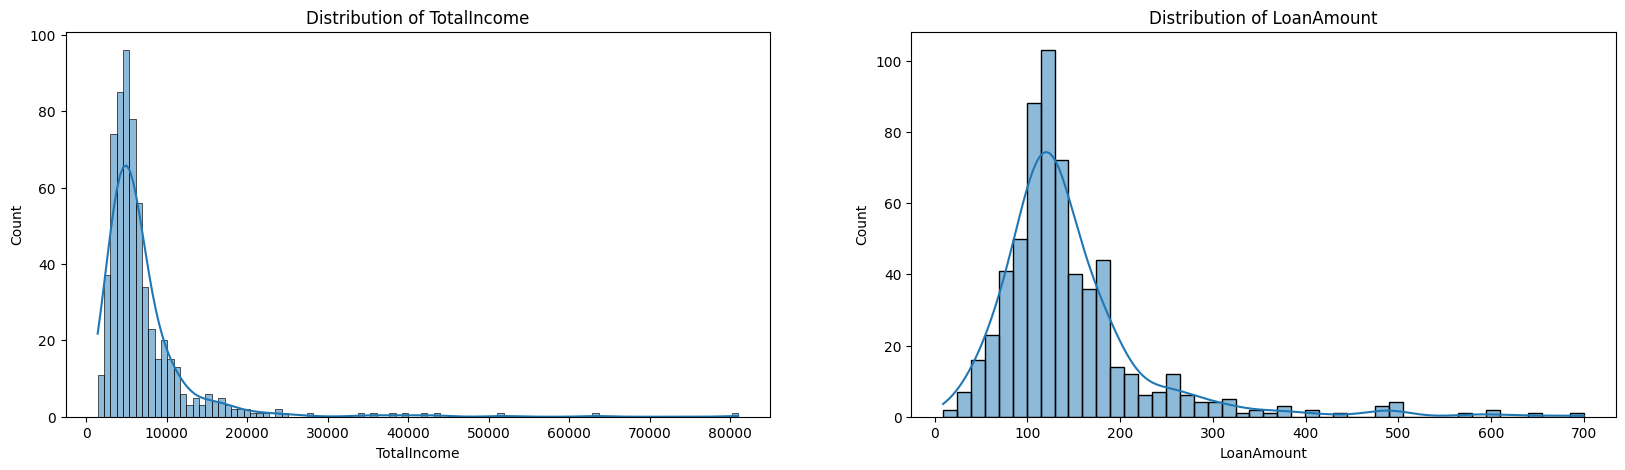

In [45]:
fig,ax = plt.subplots(1,2,figsize=(20,5))

for i,feature in enumerate(['TotalIncome','LoanAmount']):
    sns.histplot(train[feature],kde=True,ax=ax[i])
    ax[i].set_title(f'Distribution of {feature}')

* We will handle outliers on TotalIncome and LoanAmount using a log transformation.

In [46]:
for attr in ['TotalIncome','LoanAmount']:
    train[attr]=train[attr].apply(np.log1p)

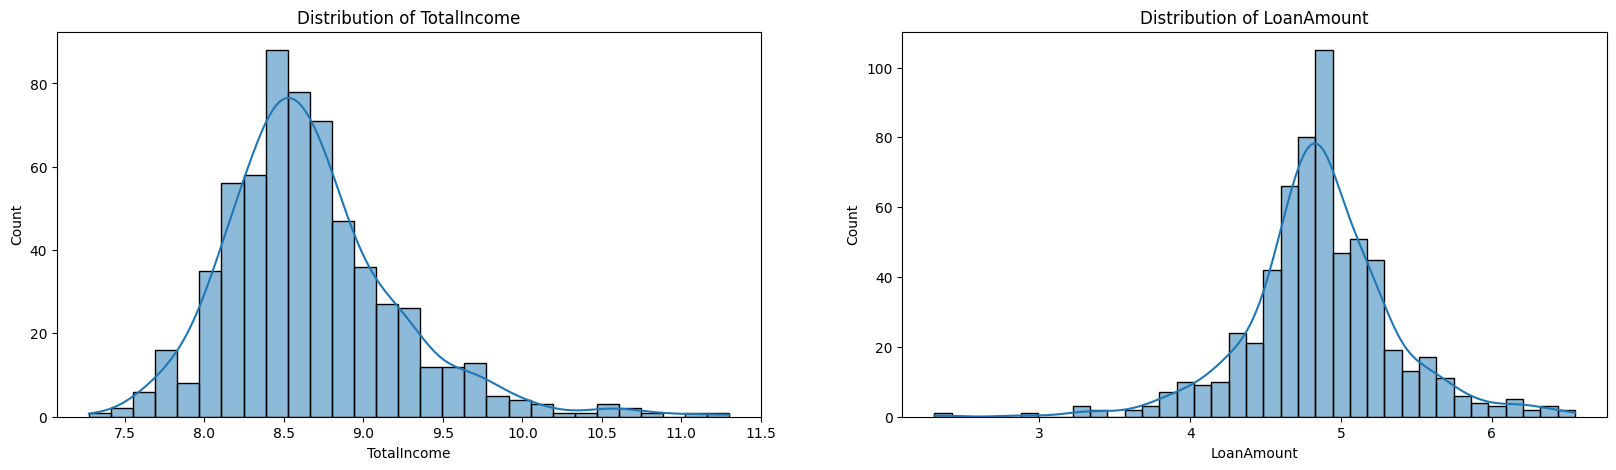

In [47]:
fig,ax = plt.subplots(1,2,figsize=(20,5))

for i,feature in enumerate(['TotalIncome','LoanAmount']):
    sns.histplot(train[feature],kde=True,ax=ax[i])
    ax[i].set_title(f'Distribution of {feature}')

* Both Total Income & LoanAmount are now uniformly distributed.

In [48]:
print(train.shape)
train.head()

(614, 9)


,Married,Dependents,Education,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,No,0,Graduate,4.859812,360.0,1.0,Urban,1,8.674197
1,Yes,1,Graduate,4.859812,360.0,1.0,Rural,0,8.714732
2,Yes,0,Graduate,4.204693,360.0,1.0,Urban,1,8.006701
3,Yes,0,Not Graduate,4.795791,360.0,1.0,Urban,1,8.505525
4,No,0,Graduate,4.955827,360.0,1.0,Urban,1,8.699681


# Applying And Comparing Models

We'll be using XGBoost, KNN and Random Forest

### Converting Categorical to Numerical

In [49]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

categorical_features = train.select_dtypes(include='object').columns

def LabelEncoding(X):
    le=LabelEncoder()
    for i in categorical_features:
        X[i]=le.fit_transform(X[i])
    return X

df_train=LabelEncoding(train)

In [50]:
df_train

,Married,Dependents,Education,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,0,0,0,4.859812,360.0,1.0,2,1,8.674197
1,1,1,0,4.859812,360.0,1.0,0,0,8.714732
2,1,0,0,4.204693,360.0,1.0,2,1,8.006701
3,1,0,1,4.795791,360.0,1.0,2,1,8.505525
4,0,0,0,4.955827,360.0,1.0,2,1,8.699681
...,...,...,...,...,...,...,...,...,...
609,0,0,0,4.276666,360.0,1.0,0,1,7.972811
610,1,3,0,3.713572,180.0,1.0,0,1,8.320448
611,1,1,0,5.537334,360.0,1.0,2,1,9.025576
612,1,2,0,5.236442,360.0,1.0,2,1,8.933796


## XGBoost

### Algorithm
* Create a single leaf tree.
* For initial tree, calculate the residuals using some initial predictions (usually taken as 0.5).
    $$ \text{Residuals} = \text{Actual Probability} - \text{Probability}_i $$
* Calculate Similarity Score Using:
    $$ \text{Similarity Score} = \frac{(\sum Residuals)^2}{\sum(Previous \, Probability_i \, (1 - Previous \, Probability_i)) + \lambda} $$
* Find a threshold to split the tree by maximizing Gain.
    $$ \text{Gain} = \text{Left}_{\text{Similarity}} + \text{Right}_{\text{Similarity}} - \text{Root}_{\text{Similarity}} $$
* A new leaf can be mode iff it is greater than the cover threshold (min_child_weight)
    $$ \text{Cover} = \sum(Previous \, Probability_i \, (1 - Previous \, Probability_i $$ 
* Keep splitting the tree till we reach the max_depth threshold.
* Prune the tree using:
    $$  \begin{cases}
    \text{Don't Prune} & \text{Gain}-\gamma >0 \\
    \text{Prune} & \text{Gain}-\gamma \leq0 \\
    \end{cases}  $$
* After the tree is constructed, calculate the output values for the leaves using:
    $$ \text{Output} = \frac{(\sum Residual_i)}{\sum(Previous \, Probability_i \, (1 - Previous \, Probability_i)) + \lambda} $$
* Find the log(odds) for the intial prediction, where:
    $$ \text{odds} = \frac{\text{p}}{1-\text{p}} $$
* And calculate the log(odds) for each leaf using:
    $$ \text{log(odds)}_i = \text{log(odds)}_{\text{intial}} + \text{Learning Rate} * \text{Output} $$
* Find new predicted values using:
    $$ \text{Probability}_i = \frac{e^{\text{log(odds)}_i}}{1+e^{\text{log(odds)}_i}} $$

* Build new trees using these predictions till we either reach max number of trees (n_estimators) or find the smallest residuals.



### Splitting the data

We'll be splitting the data into train and test

In [51]:
from sklearn.model_selection import train_test_split

X=df_train.drop(columns=['Loan_Status'])
y=df_train['Loan_Status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=255)

In [52]:
!poetry add xgboost

The following packages are already present in the pyproject.toml and will be skipped:

  - xgboost

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [53]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

### Finding the best hyperparameters

* max_depth : Maximum depth of the tree. Low max_depth may lead to underfitting (extreme bias). Thus, we need to fine tune it.

In [54]:
from sklearn.model_selection import GridSearchCV


param_grid={
    'max_depth':range(3,25,2),
    'learning_rate': [i/10.0 for i in range(1,9)],
}

xgbc=XGBClassifier(learning_rate=0.1,n_estimators=1000,objective='binary:logistic',min_child_weight=1,max_depth=5)

grid_search = GridSearchCV(xgbc, param_grid, n_jobs=4, cv=5)

grid_search.fit(X_train,y_train)

grid_search.best_params_,grid_search.best_score_

({'learning_rate': 0.2, 'max_depth': 15}, 0.7461012311901504)

In [56]:
pgrid_2={
    'subsample':[i/10.0 for i in range(1,10)],
    'colsample_bytree':[i/10.0 for i in range(1,10)],
    'colsample_bylevel':[i/10.0 for i in range(1,10)]
}

gsearch2=GridSearchCV(XGBClassifier(learning_rate=0.2,n_estimators=1000,max_depth=15,objective='binary:logistic'),param_grid=pgrid_2,n_jobs=4,cv=5)
gsearch2.fit(X_train,y_train)

gsearch2.best_params_,gsearch2.best_score_

({'colsample_bylevel': 0.1, 'colsample_bytree': 0.8, 'subsample': 0.1},
 0.7787688098495212)

In [59]:
param_grid={
    'n_estimators':range(100,1000,50),
}

xgbc=XGBClassifier(learning_rate=0.2,n_estimators=1000,objective='binary:logistic',min_child_weight=1,max_depth=15,colsample_bytree=0.8,colsample_bylevel=0.1,subsample=0.1)

grid_search = GridSearchCV(xgbc, param_grid, n_jobs=4, cv=5)

grid_search.fit(X_train,y_train)

grid_search.best_params_,grid_search.best_score_

({'n_estimators': 200}, 0.8020519835841313)

* Predicting using the fine-tuned hyperparameters

In [60]:
model_xgb=XGBClassifier(tree_method='hist',
                        max_depth=15,
                        learning_rate=0.2,
                        subsample=0.1,
                        colsample_bytree=0.8,
                        colsample_bylevel=0.1,
                        n_estimators=200)

model_xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)])

[0]	validation_0-logloss:0.61892
[1]	validation_0-logloss:0.61468
[2]	validation_0-logloss:0.61424
[3]	validation_0-logloss:0.61313
[4]	validation_0-logloss:0.58844
[5]	validation_0-logloss:0.58877
[6]	validation_0-logloss:0.59024
[7]	validation_0-logloss:0.59381
[8]	validation_0-logloss:0.59444
[9]	validation_0-logloss:0.59520
[10]	validation_0-logloss:0.59655
[11]	validation_0-logloss:0.59673
[12]	validation_0-logloss:0.57198
[13]	validation_0-logloss:0.55589
[14]	validation_0-logloss:0.55432
[15]	validation_0-logloss:0.55621
[16]	validation_0-logloss:0.55616
[17]	validation_0-logloss:0.56100
[18]	validation_0-logloss:0.56296
[19]	validation_0-logloss:0.55602
[20]	validation_0-logloss:0.54768
[21]	validation_0-logloss:0.55554
[22]	validation_0-logloss:0.55518
[23]	validation_0-logloss:0.55608
[24]	validation_0-logloss:0.55470
[25]	validation_0-logloss:0.55309
[26]	validation_0-logloss:0.55272
[27]	validation_0-logloss:0.55217
[28]	validation_0-logloss:0.55436
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.1, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

* Algorithm tries to minimize logloss

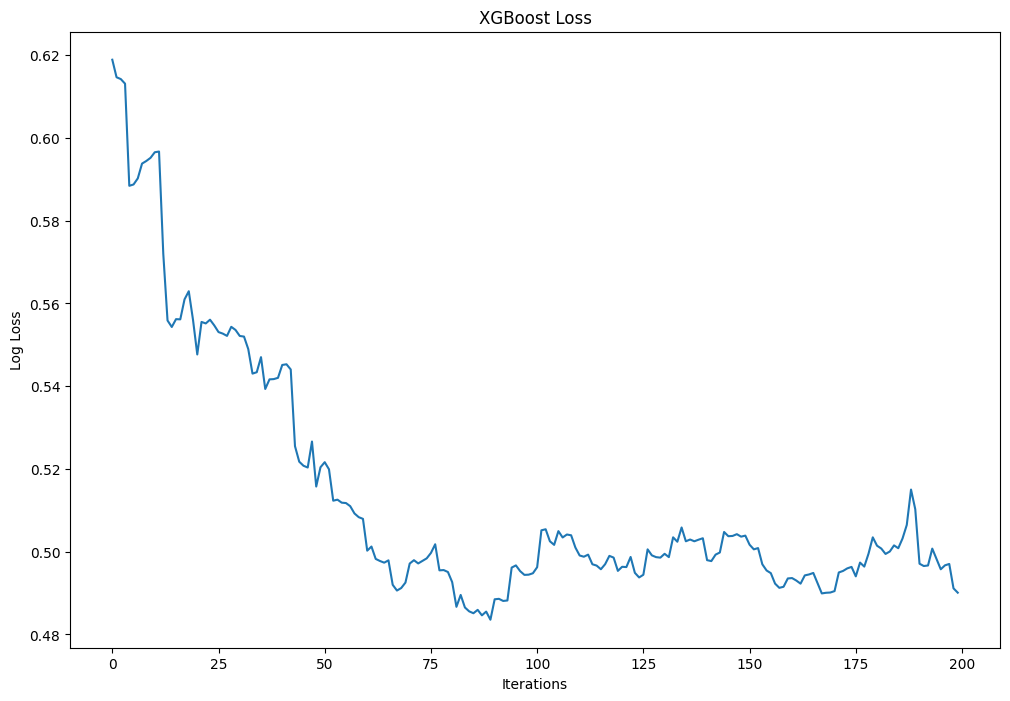

In [61]:
results=model_xgb.evals_result()
epochs=len(results['validation_0']['logloss'])
x_axis=range(0,epochs)

fig,ax=plt.subplots(figsize=(12,8))
ax.plot(x_axis,results['validation_0']['logloss'])
plt.title('XGBoost Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.show()

Text(0, 0.5, 'Feature Importance Score')

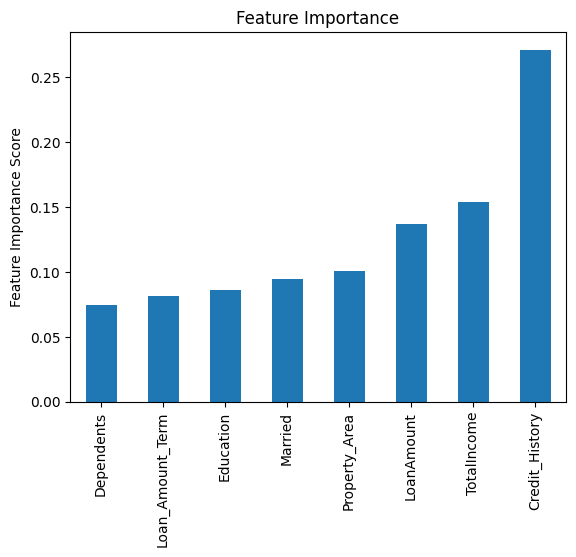

In [62]:
feat_imp=pd.Series(model_xgb.feature_importances_,index=X.columns).sort_values(ascending=True)
feat_imp.plot(kind='bar',title='Feature Importance')
plt.ylabel('Feature Importance Score')

{'True Negatives': 27, 'False Positives': 30, 'False Negatives': 6, 'True Positives': 122}
              precision    recall  f1-score   support

           0     0.8182    0.4737    0.6000        57
           1     0.8026    0.9531    0.8714       128

    accuracy                         0.8054       185
   macro avg     0.8104    0.7134    0.7357       185
weighted avg     0.8074    0.8054    0.7878       185

Total false count: 36 
Accuracy: 80.54%
F1-Score: 87.14%
Precision: 80.26%


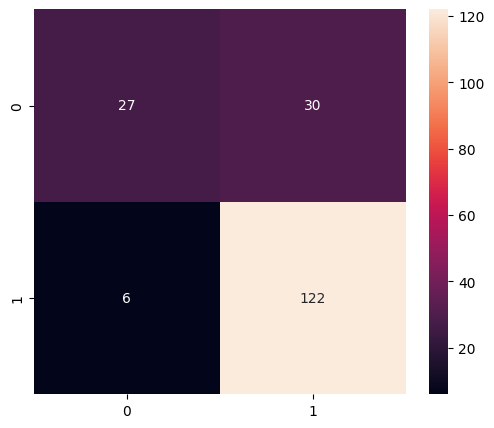

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score, precision_score, recall_score

y_pred_xgb = model_xgb.predict(X_test)

plt.figure(figsize=(6,5))
cm=confusion_matrix(y_test.values,y_pred_xgb)
labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
print(dict(zip(labels, cm.flatten())))
sns.heatmap(cm, annot=True, fmt=".0f")
print(classification_report(y_test.values,y_pred_xgb, digits=4))
false=[]

  
for i in range(len(y_test.values)):
      if y_test.values[i]!=y_pred_xgb[i]:
          false.append(i)
          
print("Total false count: %d "%len(false))  
print("Accuracy: %0.2f%%"%(accuracy_score(y_test.values, y_pred_xgb)*100))
print("F1-Score: %0.2f%%"%(f1_score(y_test.values, y_pred_xgb)*100))
print("Precision: %0.2f%%"%(precision_score(y_test.values, y_pred_xgb)*100))

# Random Forest Algorithm

In [ ]:
X = df_train.drop('Loan_Status',axis = 1)
y = df_train['Loan_Status']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming x_train and y_train are your training data
# If not, replace them with your actual training data

paramgrid = {'max_depth': list(range(1, 20, 2)),
             'n_estimators': list(range(1, 200, 20)),
              'random_state':list(range(0,100,10))}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), paramgrid)

# Fit the grid search model
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 5, 'n_estimators': 21, 'random_state': 90}


In [ ]:
rfc = RandomForestClassifier(n_estimators=21, random_state=90,max_depth=5)    #estimators- number of decision trees
rfc.fit(x_train,y_train)#random state controls the randomness and reproducability.

RandomForestClassifier(max_depth=5, n_estimators=21, random_state=90)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
accuracy_score(y_pred,y_test)

0.8699186991869918

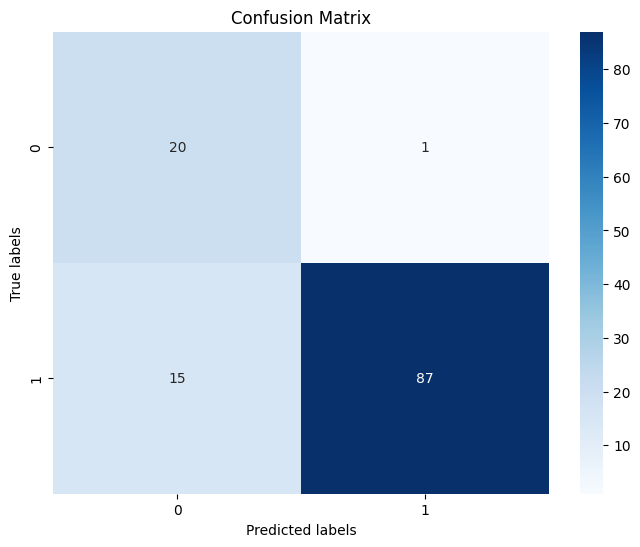

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_pred and y_test are your predicted and true labels respectively
conf_matrix = confusion_matrix(y_pred, y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1_score(y_pred,y_test)

0.9157894736842105

In [ ]:
# Get feature importances
importances = pd.Series(rfc.feature_importances_, index=X.columns)

# Sort in descending order
importances = importances.sort_values(ascending=False)

# Create a bar chart using Plotly Express
fig = px.bar(importances, x=importances.values, y=importances.index, orientation='h',
             title='Feature Importances', labels={'y': 'Feature', 'x': 'Importance'})

# Show the plot
fig.show()

## Decision Tree

### Splitting the data
We'll be splitting the data into train and test

In [ ]:
var_columns = [c for c in df_train.columns if c not in ['Loan_Status']]
y = df_train.iloc[:, 7 : 8]
df_train = df_train.drop(columns = ['Loan_Status'])
X = df_train.iloc[:, 0 : ]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=142)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Assuming x_train and y_train are your training data
# If not, replace them with your actual training data

paramgrid = {'max_depth': list(range(1, 40, 1))}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), paramgrid)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print(grid_search.best_score_)

Best Parameters: {'max_depth': 2}
0.8126777983920841


In [ ]:
clf = DecisionTreeClassifier(ccp_alpha=0.01, max_depth = 2)
clf = clf.fit(X_train, y_train)

In [ ]:
clf.get_params()

{'ccp_alpha': 0.01,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
feature_names = X.columns
feature_names

Index(['Married', 'Dependents', 'Education', 'LoanAmount', 'Loan_Amount_Term',
       'Credit_History', 'Property_Area', 'TotalIncome'],
      dtype='object')

In [ ]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.91267054, 0.        , 0.08732946])

In [ ]:
feature_importance = pd.DataFrame(clf.feature_importances_, index = feature_names).sort_values(0, ascending=False)
feature_importance

,0
Credit_History,0.912671
TotalIncome,0.087329
Married,0.000000
Dependents,0.000000
Education,0.000000
LoanAmount,0.000000
Loan_Amount_Term,0.000000
Property_Area,0.000000


In [ ]:
features = list(feature_importance[feature_importance[0]>0].index)
features

['Credit_History', 'TotalIncome']

<Axes: >

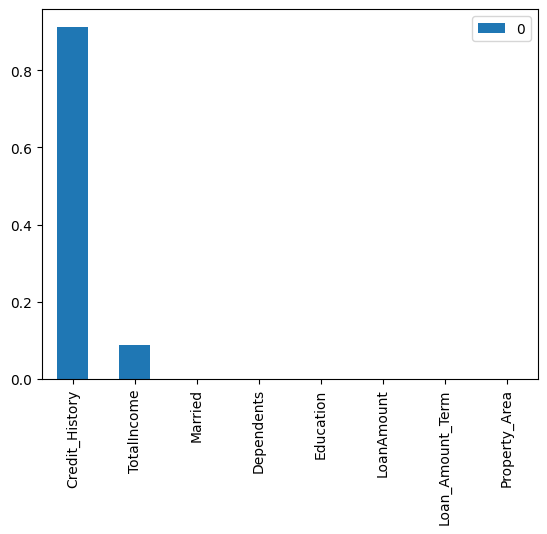

In [ ]:
feature_importance.plot(kind='bar')

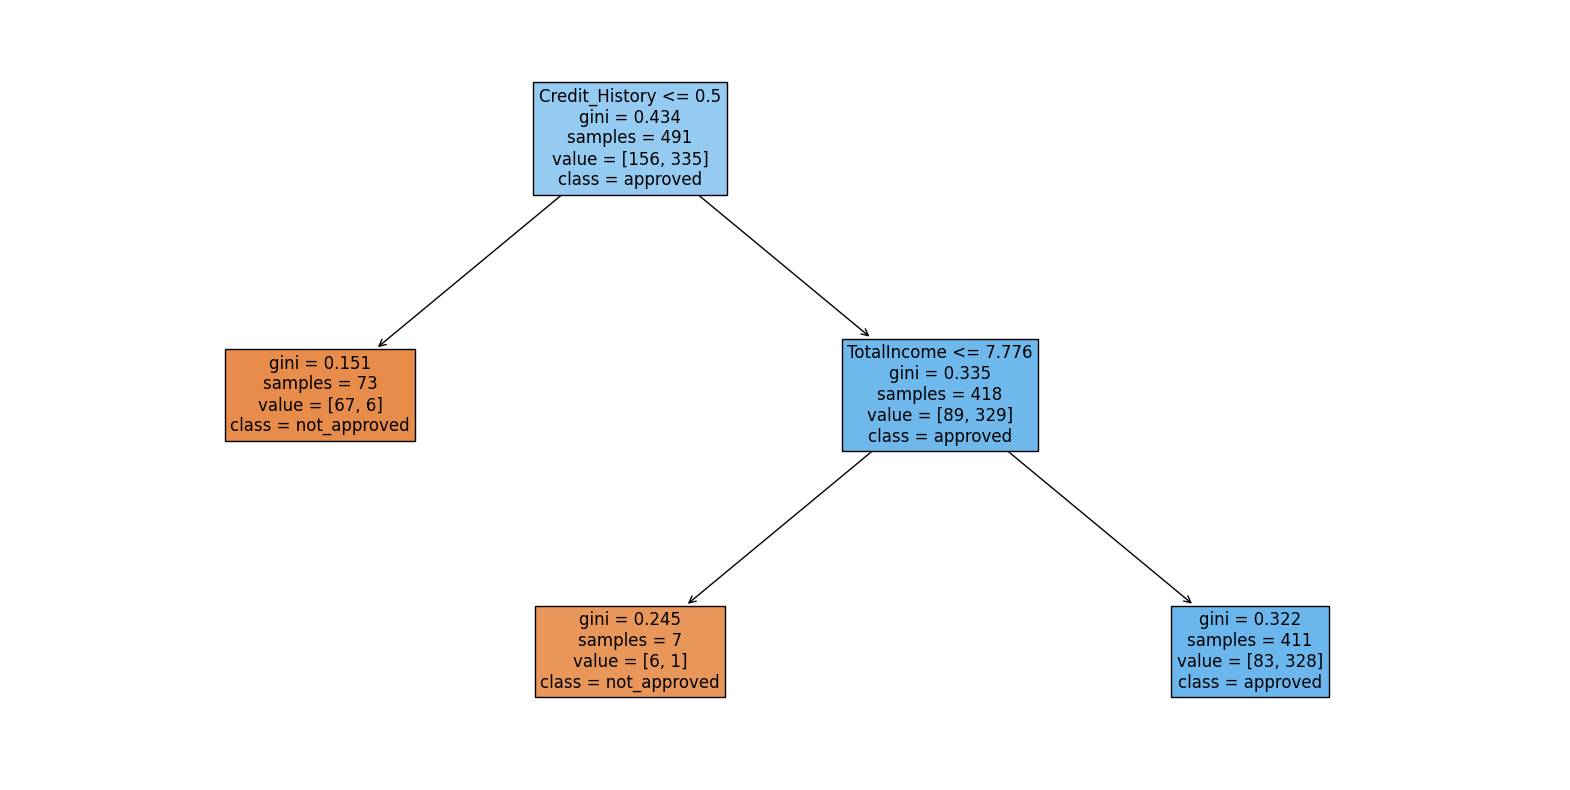

In [ ]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   class_names={0:'not_approved', 1:'approved'},
                   filled=True,
                  fontsize=12)

In [ ]:
predictions = clf.predict(X_test)
predictions

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['not_approved', 'approved']))

              precision    recall  f1-score   support

not_approved       0.84      0.44      0.58        36
    approved       0.81      0.97      0.88        87

    accuracy                           0.81       123
   macro avg       0.82      0.70      0.73       123
weighted avg       0.82      0.81      0.79       123



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=[0,1])

array([[16, 20],
       [ 3, 84]])

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, predictions)

0.9655172413793104

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, predictions)

0.8076923076923077

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)
print("Accuracy: %0.2f%%"%(accuracy_score(y_test, predictions)*100))

Accuracy: 81.30%
